## Importing Libraries

In [365]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D,LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

## Importing dataset

In [206]:

movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [207]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [208]:
movie_reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [209]:
#top 5 data
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

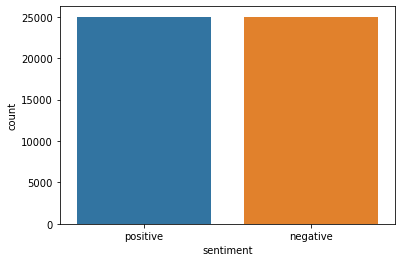

In [210]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [211]:
movie_reviews['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## As there are many tags availabe, will remove that first

In [213]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

#This code replaces anything which is enclosed withon <---> with spaces.
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [214]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

## Convert target label in numbers 1 or 0

In [217]:

y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

## Preparing train and validation data for our model

In [218]:
# 30% testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)

In [219]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Post padding of feature in order to feed feature of same size

In [120]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [221]:
vocab_size

87244

## Preparing the Embedding Matrix

In [122]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


In [123]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Model Creation

## Using Simple Neural Network

In [28]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [29]:
#model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          8724400   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 8,734,401
Trainable params: 10,001
Non-trainable params: 8,724,400
_________________________________________________________________
None


In [31]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
219/219 [==============================] - 1s 4ms/step - loss: 0.3932 - acc: 0.8257 - val_loss: 0.5369 - val_acc: 0.7423
Epoch 2/10
219/219 [==============================] - 1s 4ms/step - loss: 0.3884 - acc: 0.8264 - val_loss: 0.5784 - val_acc: 0.7291
Epoch 3/10
219/219 [==============================] - 1s 4ms/step - loss: 0.3777 - acc: 0.8318 - val_loss: 0.5561 - val_acc: 0.7391
Epoch 4/10
219/219 [==============================] - 1s 5ms/step - loss: 0.3699 - acc: 0.8361 - val_loss: 0.5814 - val_acc: 0.7307
Epoch 5/10
219/219 [==============================] - 1s 4ms/step - loss: 0.3628 - acc: 0.8394 - val_loss: 0.5683 - val_acc: 0.7347
Epoch 6/10
219/219 [==============================] - 1s 4ms/step - loss: 0.3543 - acc: 0.8461 - val_loss: 0.5922 - val_acc: 0.7271
Epoch 7/10
219/219 [==============================] - 1s 4ms/step - loss: 0.3541 - acc: 0.8476 - val_loss: 0.5788 - val_acc: 0.7359
Epoch 8/10
219/219 [==============================] - 1s 4ms/step - loss: 0.

In [32]:
score = model.evaluate(X_test, y_test, verbose=1)

469/469 [==============================] - 1s 1ms/step - loss: 0.6079 - acc: 0.7258


In [33]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6079491376876831
Test Accuracy: 0.7257999777793884


In [37]:
import matplotlib.pyplot as plt

## Text Classification using CNN

In [45]:
#CNN model Creation
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [46]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          8724400   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 8,788,657
Trainable params: 64,257
Non-trainable params: 8,724,400
_________________________________________________________________
None


In [47]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
219/219 [==============================] - 9s 40ms/step - loss: 0.4951 - acc: 0.7585 - val_loss: 0.4080 - val_acc: 0.8151
Epoch 2/6
219/219 [==============================] - 9s 40ms/step - loss: 0.3694 - acc: 0.8390 - val_loss: 0.3682 - val_acc: 0.8353
Epoch 3/6
219/219 [==============================] - 9s 40ms/step - loss: 0.3209 - acc: 0.8637 - val_loss: 0.3510 - val_acc: 0.8414
Epoch 4/6
219/219 [==============================] - 9s 39ms/step - loss: 0.2801 - acc: 0.8889 - val_loss: 0.3453 - val_acc: 0.8427
Epoch 5/6
219/219 [==============================] - 9s 40ms/step - loss: 0.2435 - acc: 0.9098 - val_loss: 0.3331 - val_acc: 0.8534
Epoch 6/6
469/469 [==============================] - 2s 4ms/step - loss: 0.3523 - acc: 0.8438


## Text Classification Using RNN

In [125]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [69]:
# Text Classification Using RNN
from keras.layers import Bidirectional
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(1, activation='softmax'))

#model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [126]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          8724400   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 8,841,777
Trainable params: 117,377
Non-trainable params: 8,724,400
_________________________________________________________________
None


In [127]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.3)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
192/192 [==============================] - 33s 173ms/step - loss: 0.5560 - acc: 0.7084 - val_loss: 0.5115 - val_acc: 0.7524
Epoch 2/10
192/192 [==============================] - 35s 183ms/step - loss: 0.4754 - acc: 0.7723 - val_loss: 0.4357 - val_acc: 0.7992
Epoch 3/10
192/192 [==============================] - 34s 179ms/step - loss: 0.4254 - acc: 0.8038 - val_loss: 0.4204 - val_acc: 0.8050
Epoch 4/10
192/192 [==============================] - 35s 181ms/step - loss: 0.3894 - acc: 0.8223 - val_loss: 0.4228 - val_acc: 0.8008
Epoch 5/10
192/192 [==============================] - 35s 181ms/step - loss: 0.3667 - acc: 0.8370 - val_loss: 0.3601 - val_acc: 0.8410
Epoch 6/10
192/192 [==============================] - 34s 179ms/step - loss: 0.3488 - acc: 0.8470 - val_loss: 0.3350 - val_acc: 0.8498
Epoch 7/10
192/192 [==============================] - 35s 183ms/step - loss: 0.3371 - acc: 0.8520 - val_loss: 0.3376 - val_acc: 0.8512
Epoch 8/10
192/192 [==============================] - 3

In [76]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3798612654209137
Test Accuracy: 0.8275333046913147


## Accuracy and Loss Plots

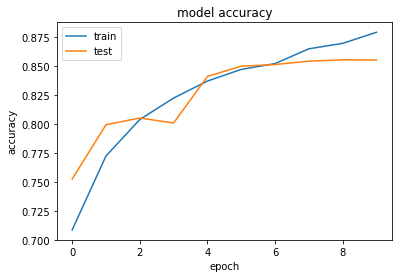

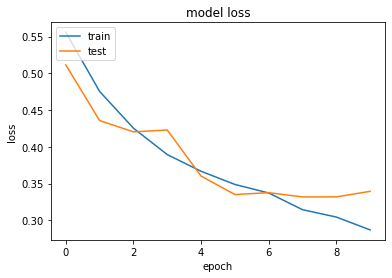

In [132]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Prediction

In [254]:
sent  = x_train[3]

In [363]:
clear = pad_sequences(
    tokenizer.texts_to_sequences([preprocess_text("Yes, because Race 3 is a film that Salman Khan's hardcore fans will watch on loop, for years to come. It will be worshipped in Salman Khan's own chain of theatres for decades as the perfect Bhai film. Race 3 has set standards that all Salman films put together haven't been able to yet.")]),
    padding='post',
    maxlen=maxlen
)


In [364]:
model.predict(clear)

array([[0.95109385]], dtype=float32)